In [152]:
# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

# Preprocessing
from imblearn.under_sampling import RandomUnderSampler #conda install conda-forge::imbalanced-learn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from imblearn.under_sampling import RandomUnderSampler 

# Pipeline and model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB

# Score of models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MOHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MOHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [153]:
#création d'une blacklist de mots de spam 
dfblacklist = pd.read_csv('spam_words.txt', header=None, on_bad_lines='skip' )
dfblacklist.rename(columns={0:'words'}, inplace=True)
dfblacklistList = dfblacklist['words'].tolist()

In [154]:
#fonction de mise en place du dataset 
def cree_df(url = "SMSSpamCollection.txt"):
    df = pd.read_csv(url, sep='\t', header=None )
    df.rename(columns={0:'type',1:'mail'}, inplace=True)
    return df

In [155]:
#fonction de préparation des données (preprocessing)
def prep(df): 

    #lowercase des message
    df['minuscule']=df['mail'].str.lower()

    #mise en place des tokens des message
    tokenizer = RegexpTokenizer(r"\b\w+\b|\d{2} \d{2} \d{2} \d{2} \d{2}")
    df['token'] = df['minuscule'].apply(lambda x: tokenizer.tokenize(x))

    #ajout d'un stopwords 
    stop = stopwords.words('english')
    df['without_stopwords']=df['token'].apply(lambda x: [word for word in x if word not in stop])

    #ajout d'un stemmer
    stemmer = PorterStemmer()
    df['PorterStemmer'] = df['without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
    
    #regroupement du traitement des données
    df['clean'] = df['without_stopwords'].apply(lambda x: " ".join(x))
    return df

In [156]:
#fonction d'ajout des features afin d'améliorer la précision des modèles
def features(df):
    
    #ajout d'une feature "longueur du message"
    df['len']=df['mail'].str.len()

    #ajout d'une feature "nombre de mots"
# df['nombre_mots']=df['mail'].str.split().str.len()
    df['nombre_mots']=df['token'].str.len()

    #ajout d'une feature permettant de vérifier si présence d'hypertexte
    pattern = r"http\S+|www.\S+"
    df['http']=df['mail'].apply(lambda x : True if re.search(pattern, x) else False)

    #ajout d'une feature permettant de vérifier la présence de chiffre 
    pattern = r"/^[\(]?[\+]?(\d{2}|\d{3})[\)]?[\s]?((\d{6}|\d{8})|(\d{3}[\*\.\-\s]){3}|(\d{2}[\*\.\-\s]){4}|(\d{4}[\*\.\-\s]){2})|\d{8}|\d{10}|\d{12}$/"
    df['phone']=df['mail'].apply(lambda x : True if re.search(pattern, x) else False)
    
    #ajout d'une feature permettant de vérifier la présence de mail
    #pattern = r"[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+(?:\.[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+)*@(?:[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?\.)+[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?"
    #df['mail_compt']=df['mail'].apply(lambda x = 'True' : re.findall(pattern, x) else x = 'False')

    #ajout d'une feature permettant de vérifier la présence de mots blacklisté 
    df['blacklist']=df['token'].apply(lambda x: len([ word for word in x if word  in dfblacklistList]))
    return df

In [157]:
#fonction permettant la spéaration de la target des autres colonnes (création X et y)

def spliteur(df):
    X = df.drop(columns = ['type'], axis=1)
    y = df['type']
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    #return train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    return train_test_split(X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)

In [158]:
#fonction création du modèle 
def ModelCreateur(X_train, y_train, classifier):

    column_num  = ['len','nombre_mots','blacklist']
    column_bool = ['http','phone']
    
    #Transformation des variables texte
    transfo_text_TFid = Pipeline(steps=[
        ('Tfid', TfidfVectorizer(lowercase=False, decode_error='ignore', analyzer='char_wb', ngram_range=(2, 2)))
        
    ])

#Application des étapes sur tout le dataset
    if classifier == "ComplementNB()" or "MultinomialNB()":
        preparation = ColumnTransformer(
        transformers=[
        ('TFid&data', transfo_text_TFid , 'clean'), #TFIDF ne prend pas de listes comme arguments
        # ('CountVect&data', transfo_text_CountVect , 'clean'),
            ('Scaler&data',MinMaxScaler(), column_num),
            ('BoolEncoder',OrdinalEncoder(), column_bool)
        ])
    else : 
        preparation = ColumnTransformer(
        transformers=[
        ('TFid&data', transfo_text_TFid , 'clean'), #TFIDF ne prend pas de listes comme arguments
        # ('CountVect&data', transfo_text_CountVect , 'clean'),
            ('Scaler&data',RobustScaler(), column_num),
            ('BoolEncoder',OrdinalEncoder(), column_bool)
        ])
    
    #relie l'algorithme avec le modèle
    model = Pipeline([
    ('vectorizer', preparation),
    ('classifier', classifier)
    ])
    #Fit le modèle
    model.fit(X_train, y_train)
    return model

In [159]:
#fonction permettant de connaître le score de notre modèle
def AfficherScores(y_test, y_pred,model,x):
    
    #affiche l'accuracy du modèle
    print("Accuracy:", accuracy_score(y_test, y_pred))
    #affiche la classification report du modèle
    print(classification_report(y_test, y_pred))
    #affiche les graphiques du modèle
    """plt.hist(model.decision_function(x), bins=50)
    plt.show()"""

In [160]:
# fonction qui affiche la matrice de confusion du modèle
def matrixconf(y_test,y_pred):
    #affiche la matrice de confusion du modèle
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [161]:
#fonction permettant de tester le modèle
def testModel(sms,model):
    #mise en place d'un input
    input_sms     = [sms]
    #transformation en dataframe afin de l'utiliser correctement
    df_sms        = pd.DataFrame(input_sms)
    df_sms.rename(columns={0:'mail'}, inplace=True)
    #mise en place du preprocessing
    df_sms        = prep(df_sms)
    #mise en place des feature
    df_sms        = features(df_sms)
    #prediction 
    result = model.predict(df_sms)
    return result

In [162]:
#mise en place des modèles
classifier1 = LogisticRegression(solver='liblinear', C=1e3)
classifier2 = KNeighborsClassifier(7)

classifier3 = ComplementNB()                                        
classifier4 = MultinomialNB()                                     
classifier5 = BernoulliNB(force_alpha=True)

classifier6 = SVC()                                     
classifier7 = SVC(gamma=2, C=1, random_state=42)                   

classifier8 = RidgeClassifier(tol=1e-2, solver="sparse_cg")          
classifier9 = RandomForestClassifier(max_depth=200, random_state=42) 
classifier10 = DecisionTreeClassifier()                             

list_model = [classifier1,classifier2,classifier3,classifier4,classifier5,classifier6,classifier7,classifier8,classifier9,classifier10]

<Axes: title={'center': 'blacklist'}, xlabel='type'>

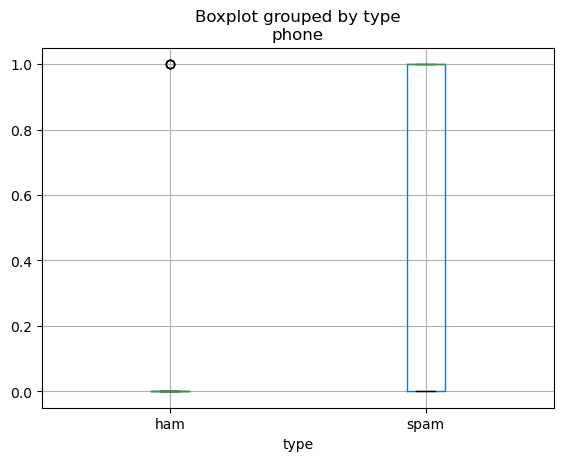

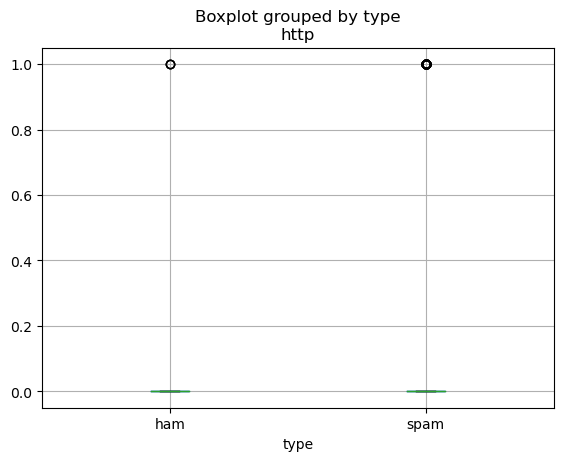

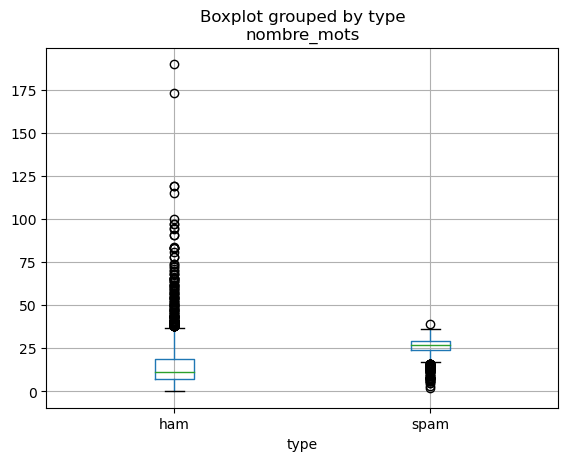

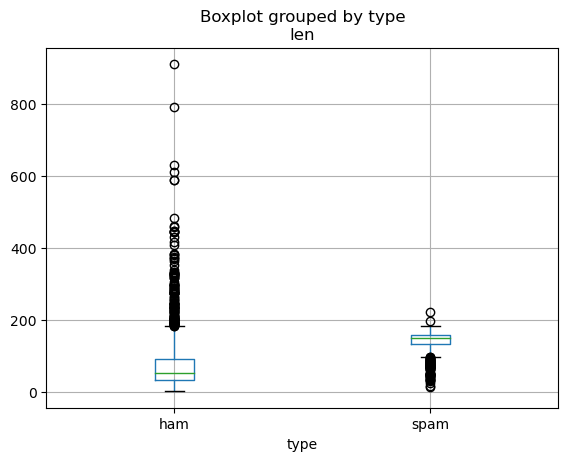

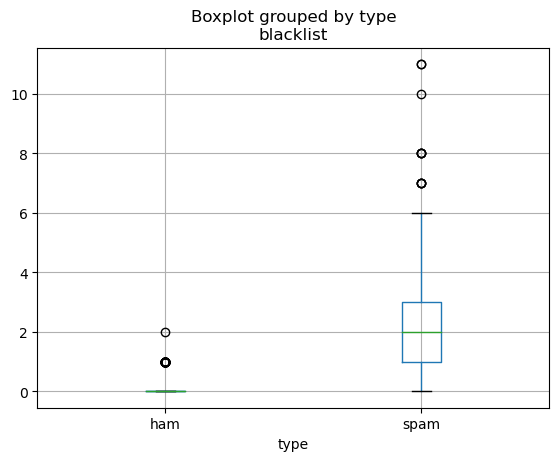

In [163]:
dfModel = cree_df("SMSSpamCollection.txt")
dfModel = prep(dfModel)
dfModel = features(dfModel)

# dfModel[['type', 'phone']].boxplot(column='phone', by='type')
# dfModel[['type', 'http']].boxplot(column='http', by='type')
dfModel[['type', 'nombre_mots']].boxplot(column='nombre_mots', by='type')
dfModel[['type', 'len']].boxplot(column='len', by='type')
dfModel[['type', 'blacklist']].boxplot(column='blacklist', by='type')


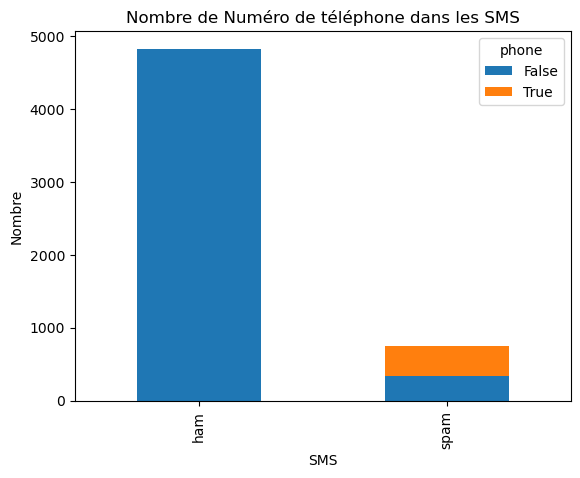

In [164]:

pivot_table = dfModel[['type', 'phone']].pivot_table(index='type', columns='phone', aggfunc=len, fill_value=0)
pivot_table.plot(kind='bar', stacked=True)

plt.title('Nombre de Numéro de téléphone dans les SMS')
plt.xlabel('SMS')
plt.ylabel('Nombre')
plt.show()

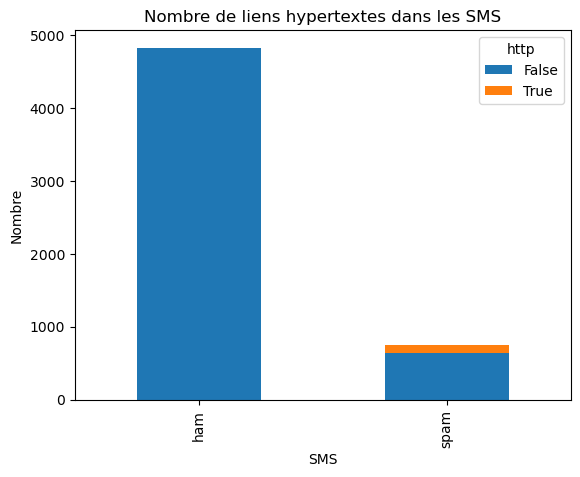

In [165]:
pivot_table = dfModel[['type', 'http']].pivot_table(index='type', columns='http', aggfunc=len, fill_value=0)
pivot_table.plot(kind='bar', stacked=True)

plt.title('Nombre de liens hypertextes dans les SMS')
plt.xlabel('SMS')
plt.ylabel('Nombre')
plt.show()

In [166]:
dfModel = cree_df("SMSSpamCollection.txt")
dfModel = prep(dfModel)
dfModel = features(dfModel)
X_train, X_test, y_train, y_test = spliteur(dfModel)

In [167]:



"""ACP, function transformer et graphique"""

'ACP, function transformer et graphique'

In [168]:
model_lm=ModelCreateur(X_train, y_train, classifier3)
model_lm

Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('TFid&data',
                                                  Pipeline(steps=[('Tfid',
                                                                   TfidfVectorizer(analyzer='char_wb',
                                                                                   decode_error='ignore',
                                                                                   lowercase=False,
                                                                                   ngram_range=(2,
                                                                                                2)))]),
                                                  'clean'),
                                                 ('Scaler&data', MinMaxScaler(),
                                                  ['len', 'nombre_mots',
                                                   'blacklist']),
                                                 ('BoolEncoder',
                                                  OrdinalEncoder(),
                                                  ['http', 'phone'])])),
                ('classifier', ComplementNB())])

In [169]:
#input =  'Hi Nick. This is to remind you about the $75 minimum payment on your credit card ending in XXXX. Payment is due on 01/01. Pls visit order.com to make your payment'

# for i in list_model:
#     model_lm=ModelCreateur(X_train, y_train, i)
#     model_lm
#     print('model utilisé:', i)
#     y_pred = testModel(X_test,model_lm)
#     matrixconf(y_test,y_pred)
#     AfficherScores(y_test, y_pred,model_lm,X_test)
#     model_disp = RocCurveDisplay.from_estimator(model_lm,X_test,y_test)

model utilisé: LogisticRegression(C=1000.0, solver='liblinear')
Accuracy: 0.9632107023411371
              precision    recall  f1-score   support

         ham       0.94      0.99      0.96       150
        spam       0.99      0.93      0.96       149

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299

model utilisé: KNeighborsClassifier(n_neighbors=7)
Accuracy: 0.959866220735786
              precision    recall  f1-score   support

         ham       0.93      0.99      0.96       150
        spam       0.99      0.93      0.96       149

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299

model utilisé: ComplementNB()
Accuracy: 0.9331103678929766
              precision    recall  f1-score   support

         ham       0.89      0.99      0.94       150
      

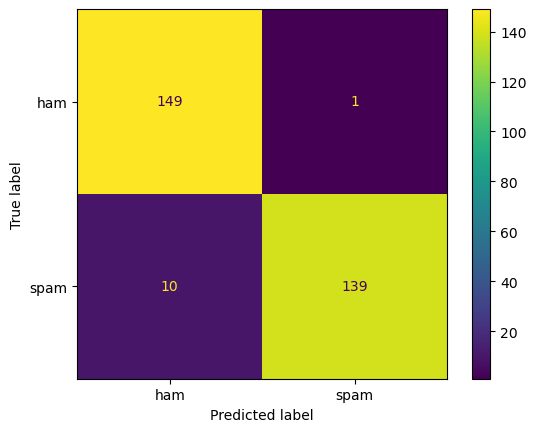

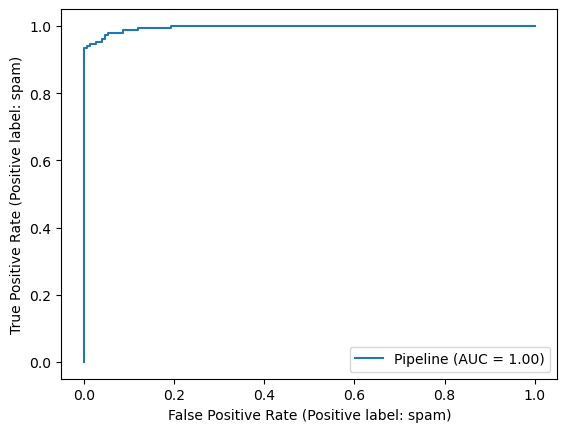

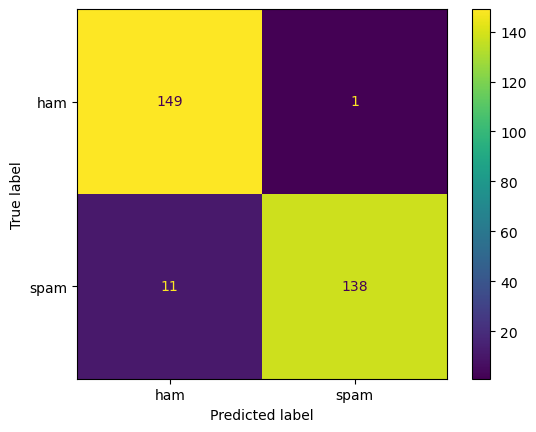

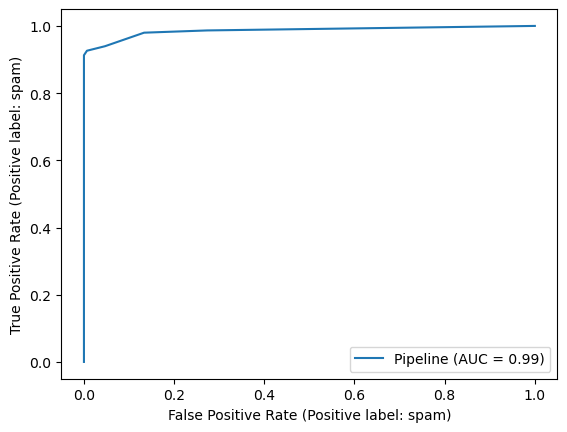

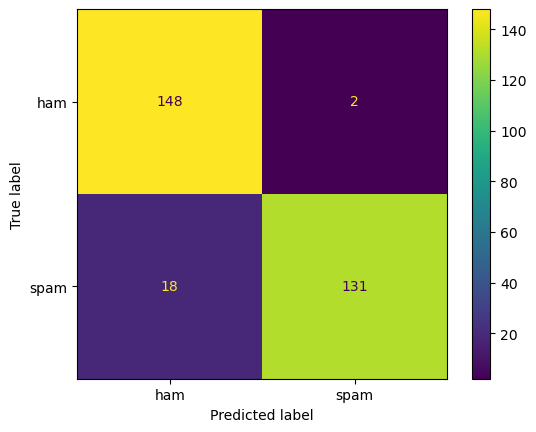

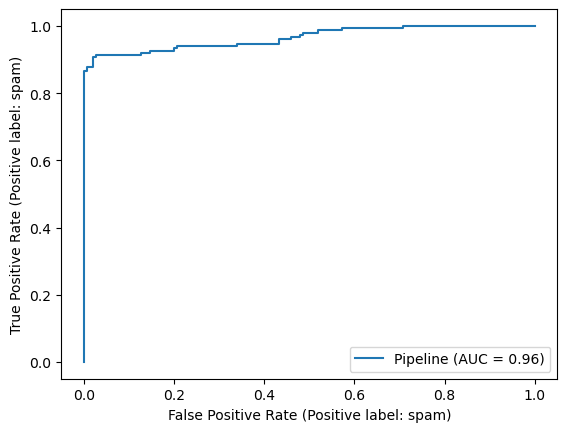

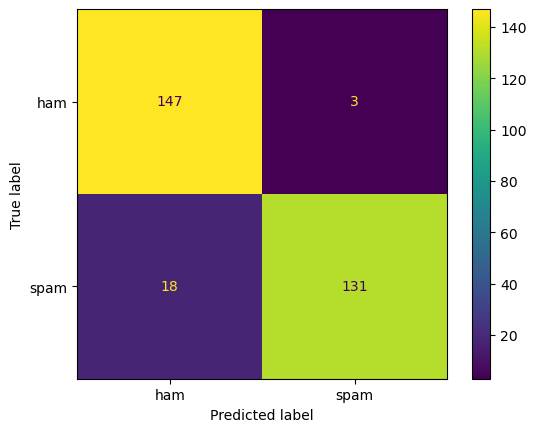

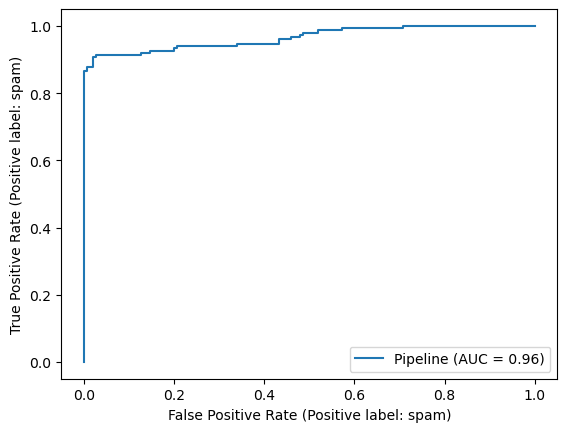

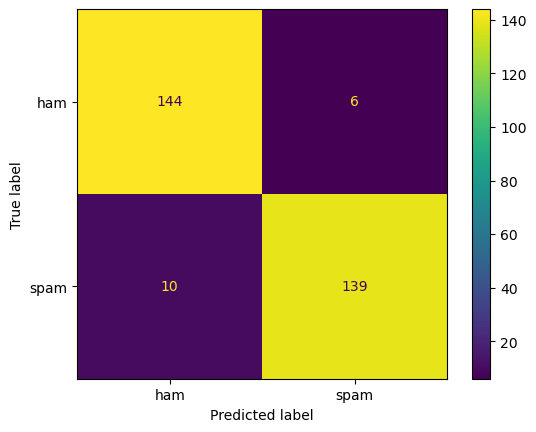

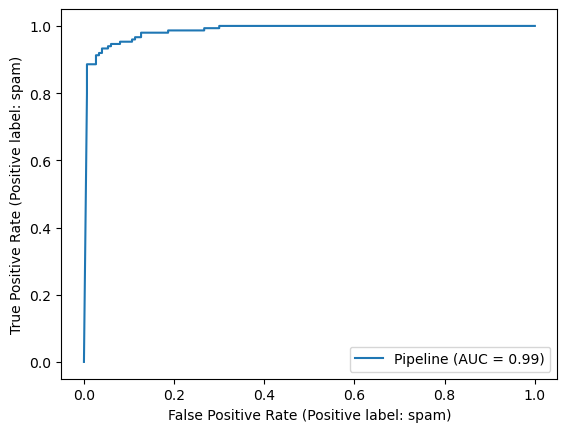

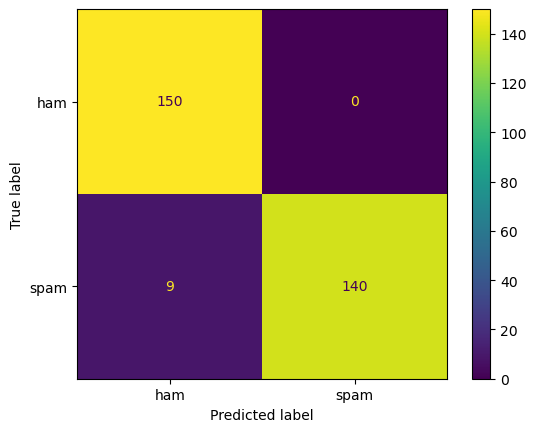

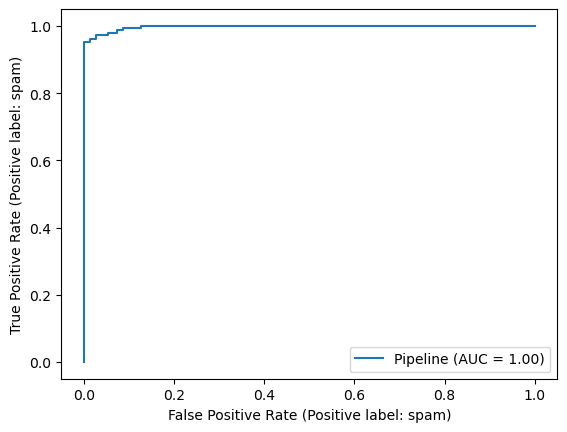

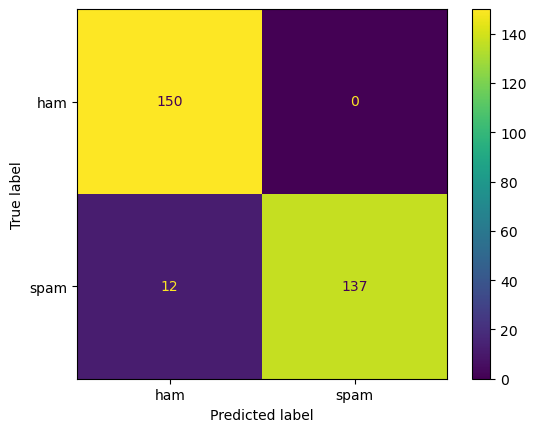

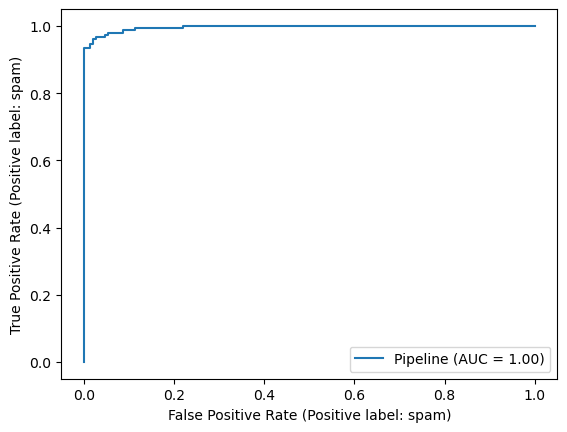

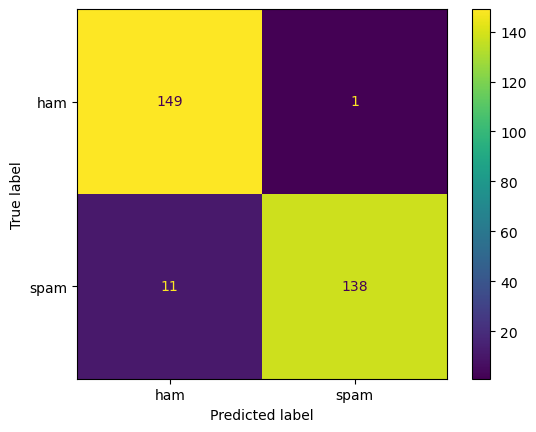

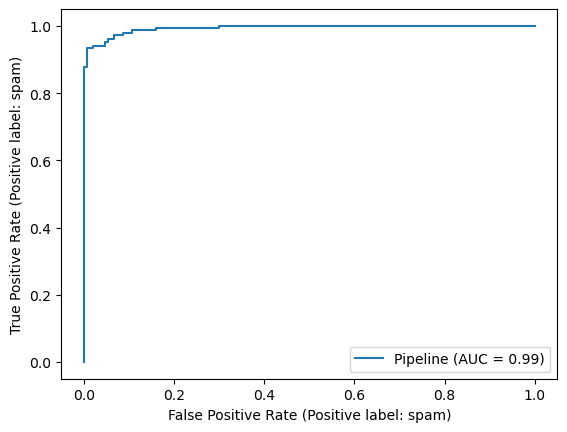

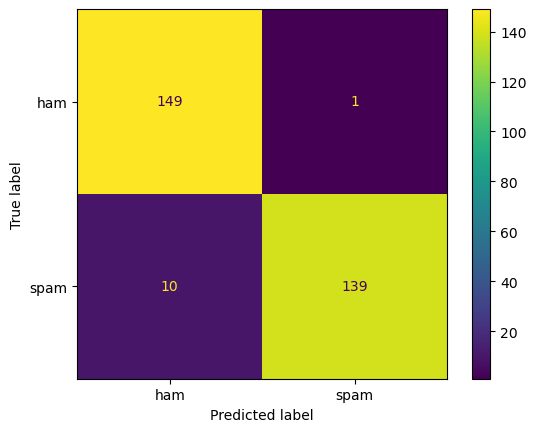

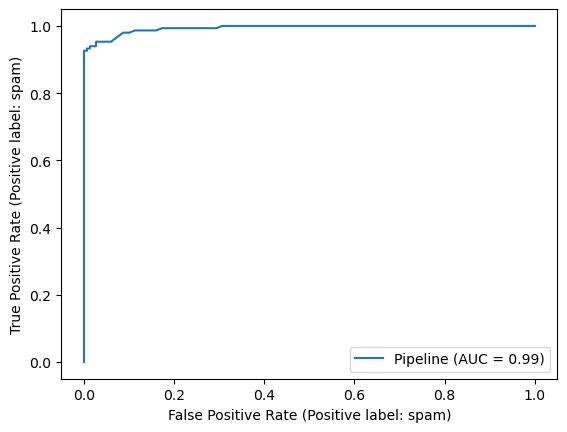

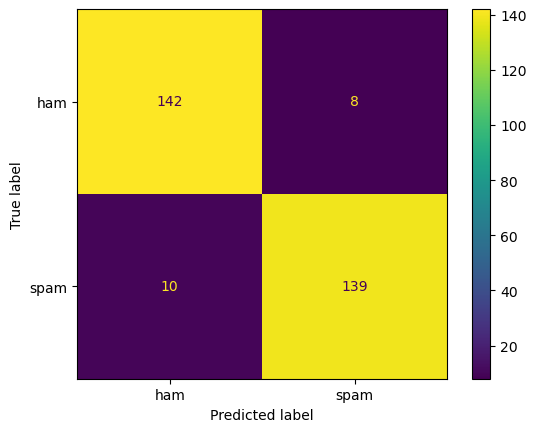

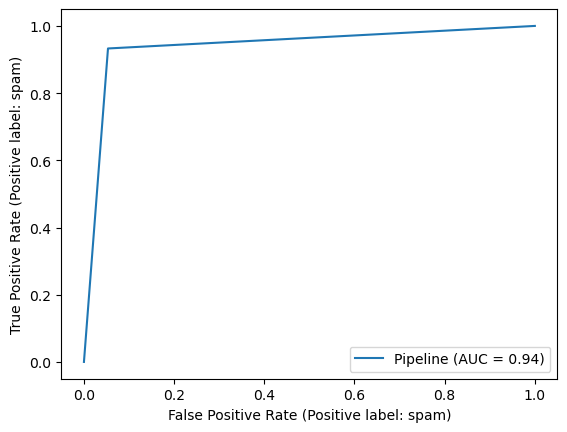

In [176]:
for i in list_model:
    model_lm=ModelCreateur(X_train, y_train, i)
    # print(i,':',testModel(model_lm))
    print('model utilisé:', i)
    y_pred = model_lm.predict(X_test)
    matrixconf(y_test,y_pred)
    AfficherScores(y_test, y_pred,model_lm,X_test)
    model_disp = RocCurveDisplay.from_estimator(model_lm,X_test,y_test)